In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys


N_up = 1
nb_dir = '/'.join(os.getcwd().split('/')[:-N_up] + ['src'])
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    print(nb_dir)
    
    

/scratch4/ja666/dip_bayesian_ext/src


In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from math import factorial



In [3]:
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [4]:
from direct_inference.utils import *
from direct_inference.models import *
from direct_inference.objectives import *

## setup problem

In [5]:
img_side = 28
max_angles = 100
noise_prop = 0.15

full_op_mat = gen_op_mat(img_side, max_angles)

full_op_tensor = full_op_mat.reshape(max_angles, -1, img_side**2)



/var/home/ja666/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [6]:
initial_angles = 10
ratio = max_angles / initial_angles
assert round(ratio) == ratio
ratio = int(ratio)

print(full_op_tensor.shape)
op_mat = full_op_tensor[::ratio].reshape(-1, img_side**2)
print(op_mat.shape)


(100, 41, 784)
(410, 784)


## load datapoint

In [7]:
kmnist_path = '/scratch4/ja666/dip_bayesian_ext/kmnist'

train_dset = iter(load_KMNIST_dataset(kmnist_path, batchsize=1, train=True))
test_dset = iter(load_KMNIST_dataset(kmnist_path, batchsize=1, train=False))





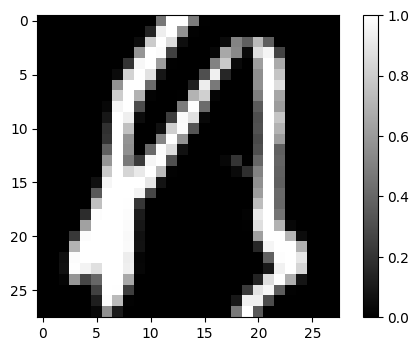

In [8]:
(example_image, _) = next(train_dset)

image_np = example_image.numpy().flatten()

observation = op_mat @ image_np
noise_std = noise_prop * np.abs(observation).mean()
observation += np.random.randn(*observation.shape) * noise_std

plt.figure(dpi=100)
plt.imshow(example_image.squeeze(), cmap='gray')
plt.colorbar()


## build some non-data dependent basis

In [9]:
## we choose this funky basis, which is just designed to resemble a random assortment of things spit out from a NN
n_rbf_samples = 1000
n_laplace_samples = 1000
n_polynomial = 0 # includes 0th order term

coords = coords_2d(img_side)
key = random.PRNGKey(0)

cos_scale = 1

# we are going to define a sum kernel 
Gauss_params = jax.random.normal(key, shape=(n_rbf_samples, coords.shape[1]))
Gauss_biases = (jax.random.uniform(key, shape=(1, n_rbf_samples)) - 0.5) * 2 * np.pi

key = random.split(key)[0]
Laplace_params = jax.random.laplace(key, shape=(n_laplace_samples, coords.shape[1]))
Laplace_biases = (jax.random.uniform(key, shape=(1, n_laplace_samples)) - 0.5) * 2 * np.pi


rbf_basis = jnp.cos((coords @ Gauss_params.T * cos_scale) + Gauss_biases) / jnp.sqrt(n_rbf_samples)
laplace_basis = jnp.cos((coords @ Laplace_params.T * cos_scale) + Laplace_biases) / jnp.sqrt(n_laplace_samples)
poly_basis = jnp.stack([(coords ** i).sum(axis=1) / (4 * factorial(i)) for i in range(n_polynomial+1)], axis=1)

design_mat = jnp.concatenate([rbf_basis, laplace_basis, poly_basis], axis=1)

print(design_mat.shape)


(784, 2001)


## sample from the prior

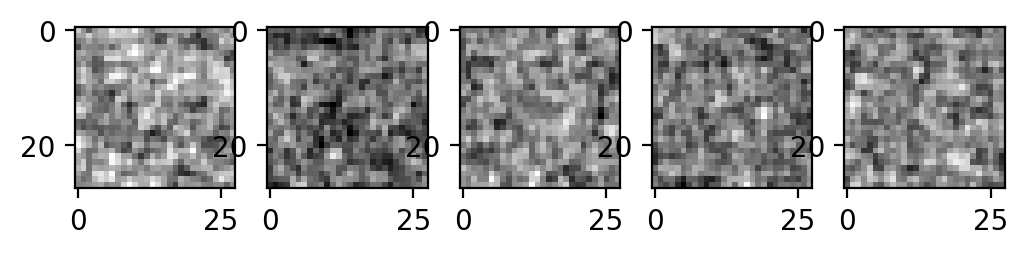

In [10]:
key = random.split(key)[0]
n_samples = 5
samples_reconstruction_eps = jax.random.normal(key, shape=(design_mat.shape[1], n_samples))

prec = 10

reconstructions = design_mat @ samples_reconstruction_eps * (prec ** -0.5)

fig, ax = plt.subplots(1,5,dpi=200)
ax[0].imshow(reconstructions[:,0].reshape(28,28), cmap='gray', vmin=-1, vmax=1)
ax[1].imshow(reconstructions[:,1].reshape(28,28), cmap='gray', vmin=-1, vmax=1)
ax[2].imshow(reconstructions[:,2].reshape(28,28), cmap='gray', vmin=-1, vmax=1)
ax[3].imshow(reconstructions[:,3].reshape(28,28), cmap='gray', vmin=-1, vmax=1)
ax[4].imshow(reconstructions[:,4].reshape(28,28), cmap='gray', vmin=-1, vmax=1)


## compute posterior

In [182]:
observation.shape

(410,)

In [11]:

prec = 20
op_design_mat = op_mat @ design_mat


prec_mat = (op_design_mat.T @ op_design_mat) * noise_std ** (-2) + prec * np.eye(design_mat.shape[1])

cov_mat = jnp.linalg.inv(prec_mat)
cov_chol = jnp.linalg.cholesky(cov_mat)

map_weights = cov_mat @ op_design_mat.T @ observation * noise_std ** (-2)

map_reconstruction = design_mat @ map_weights

cov_reconstruction = design_mat @ cov_mat @ design_mat.T

key = random.split(key)[0]
n_samples = 3
samples_reconstruction_eps = jax.random.normal(key, shape=(map_weights.shape[0], n_samples))
samples_reconstruction = map_reconstruction[:,None] + design_mat @ cov_chol @ samples_reconstruction_eps



## view results

there is independence between the covariance and the observation values

Text(0.5, 1.0, 'sample')

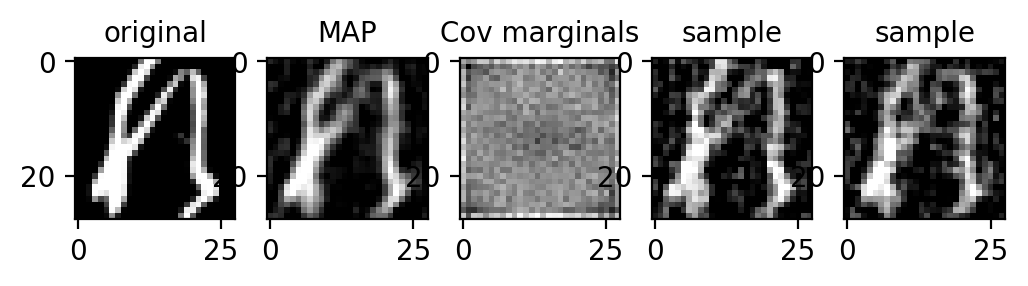

In [12]:
fig, ax = plt.subplots(1,5,dpi=200)

ax[0].imshow(example_image.squeeze().reshape(28,28), cmap='gray', vmin=0, vmax=1)
ax[0].set_title('original', fontsize=10)
ax[1].imshow(map_reconstruction.reshape(28,28), cmap='gray', vmin=0, vmax=1)
ax[1].set_title('MAP', fontsize=10)
ax[2].imshow(cov_reconstruction.diagonal().reshape(28,28), cmap='gray')
ax[2].set_title('Cov marginals', fontsize=10)
ax[3].imshow(samples_reconstruction[:,1].reshape(28,28), cmap='gray', vmin=0, vmax=1)
ax[3].set_title('sample', fontsize=10)
ax[4].imshow(samples_reconstruction[:,2].reshape(28,28), cmap='gray', vmin=0, vmax=1)
ax[4].set_title('sample', fontsize=10)


# Design step


Note that EMIG is the same as sum of log-diagonals of y-space covariance mtx (there is an additive noise variance factor missing but it doesnt change optima of monotonic log function)

### isotropic model assume diag across detector pixels

In [351]:


def linear_posterior_matheron(y_obs_cov_chol, f_cov, A_obs, A_non_obs, noise_std):

    dx = f_cov.shape[0]
    dy = A_obs.shape[0]
    f_cov_chol = jnp.linalg.cholesky(f_cov) # dx x dx

    f_noise = np.random.randn(dx, Nsamples)
    y_noise = np.random.randn(dy, Nsamples)

    f_samples = f_cov_chol @ f_noise # df x Nsamples
    y_samples = A_obs @ f_samples + y_noise * noise_std  # dy x Nsamples


    y_post_samples = jax.scipy.linalg.cho_solve((y_obs_cov_chol, True), y_samples) # dy x Nsamples
    f_post_samples = f_samples - f_cov @ A_obs.T @ y_post_samples # dx x Nsamples
    y_non_obs_samples = A_non_obs @ f_post_samples  # dy_complement x Nsamples

    return y_non_obs_samples, f_post_samples

    
# def sampled_diag_EIG(y_samples_per_detector_per_angle, noise_std):

#     # y_samples_per_detector_per_angle -> (angles, deterctors, samples)
    
#     log_var_per_detector_per_angle = jnp.log( (y_samples_per_detector_per_angle ** 2).mean(axis=-1) + (noise_std ** 2) ) # log variance per detector pixel per angle
#     diag_EIG_per_angle = log_var_per_detector_per_angle.sum(axis=1) # sum across detector pixels
#     return diag_EIG_per_angle


def sampled_EIG(y_samples_per_detector_per_angle, noise_std):
    
    # y_samples_per_detector_per_angle -> (angles, deterctors, samples)
    # TODO: make parallelised accross angles (torch.bmm)
    
    Nsamples = y_samples_per_detector_per_angle.shape[-1]
    
    angle_sample_full_eig = []
    for i_angle in range(y_samples_per_detector_per_angle.shape[0]):
        angle_cov = (y_samples_per_detector_per_angle[i_angle] @ y_samples_per_detector_per_angle[i_angle].T) / Nsamples
        
        angle_cov = np.array(angle_cov)
        
        angle_cov[np.diag_indices(angle_cov.shape[0])] += (noise_std ** 2)
    
        s, EIG = jnp.linalg.slogdet(angle_cov)
        assert s == 1
        angle_sample_full_eig.append(EIG)
    

    return jnp.stack(angle_sample_full_eig)



def y_var(y_samples_per_detector_per_angle, noise_std):
    # y_samples_per_detector_per_angle -> (angles, deterctors, samples)
    
    var_per_detector_per_angle = (y_samples_per_detector_per_angle ** 2).mean(axis=-1) + (noise_std ** 2) # variance per detector pixel per angle
    diag_var_per_angle = var_per_detector_per_angle.sum(axis=1) # sum across detector pixels
    return diag_var_per_angle
    

def x_var(y_samples_per_detector_per_angle, x_samples, full_op_tensor, noise_std):
    
    # y_samples_per_detector_per_angle -> (angles, deterctors, samples)
    # x_samples -> (pixels, samples)
    # full_op_tensor -> (angles, detectors, pixels)
    #
    
    Nsamples = y_samples_per_detector_per_angle.shape[-1]
    x_cov = x_samples @ x_samples.T / Nsamples
    
    per_angle_x2_A = full_op_tensor @ (x_cov @ x_samples)
    
    angle_sample_full_xvar = []
    for i_angle in range(y_samples_per_detector_per_angle.shape[0]):
        angle_cov = (y_samples_per_detector_per_angle[i_angle] @ y_samples_per_detector_per_angle[i_angle].T) / Nsamples
        
        angle_cov = np.array(angle_cov)
        angle_cov[np.diag_indices(angle_cov.shape[0])] += (noise_std ** 2)
        angle_cov_inv = jnp.linalg.inv(angle_cov) # detectors x detectors
        
        angle_x_var_mat = y_samples_per_detector_per_angle[i_angle].T @ angle_cov_inv @ per_angle_x2_A[i_angle]
        
        angle_sample_full_xvar.append(angle_x_var_mat.trace() / Nsamples)
    

    return jnp.stack(angle_sample_full_xvar)




In [362]:


isotropic_prec = 0.5
Nsamples = 10000
f_cov =  (isotropic_prec ** -1) * np.eye(op_mat.shape[1]) # Will be non identity for GP


y_obs_cov = np.array(op_mat @ f_cov @ op_mat.T)
y_obs_cov[np.diag_indices(y_obs_cov.shape[0])] += (noise_std ** 2)  # dy x dy
y_obs_cov_chol = jnp.linalg.cholesky(y_obs_cov)  # TODO: we can append to this with new angles and pass directly


y_non_obs_samples, f_post_samples = linear_posterior_matheron(y_obs_cov_chol=y_obs_cov_chol, f_cov=f_prior_cov, A_obs=op_mat,
                                              A_non_obs=full_op_mat, noise_std=noise_std)

print(f_post_samples.shape)

y_samples_per_detector_per_angle = y_non_obs_samples.reshape(max_angles, -1, Nsamples)

# sampled_diag_EIG_ = sampled_diag_EIG(y_samples_per_detector_per_angle, noise_std)
y_var_ = y_var(y_samples_per_detector_per_angle, noise_std)
sampled_EIG_ = sampled_EIG(y_samples_per_detector_per_angle, noise_std)
x_var_ = x_var(y_samples_per_detector_per_angle, f_post_samples, full_op_tensor, noise_std)



(784, 10000)


In [363]:
x_var_.shape


(100,)

## dont assume diag accross detector pixels

In [364]:

# isotropic_prec_mat = (op_mat.T @ op_mat) * noise_std ** (-2) + isotropic_prec * np.eye(op_mat.shape[1])
# isotropic_post_cov_mat = jnp.linalg.inv(isotropic_prec_mat)

# angle_full_eig = []
# for i_angle in range(full_op_tensor.shape[0]):
    
#     angle_cov = (full_op_tensor[i_angle] @ isotropic_post_cov_mat @ full_op_tensor[i_angle].T + (noise_std ** 2) * np.eye(full_op_tensor.shape[1]))
#     s, EIG = jnp.linalg.slogdet(angle_cov)
# #     EIG = jnp.log(jnp.diag(angle_cov)).sum()
#     angle_full_eig.append(EIG)
    

# angle_full_eig = np.stack(angle_full_eig)
# # isotropic_cov_chol = jnp.linalg.cholesky(isotropic_cov_mat)



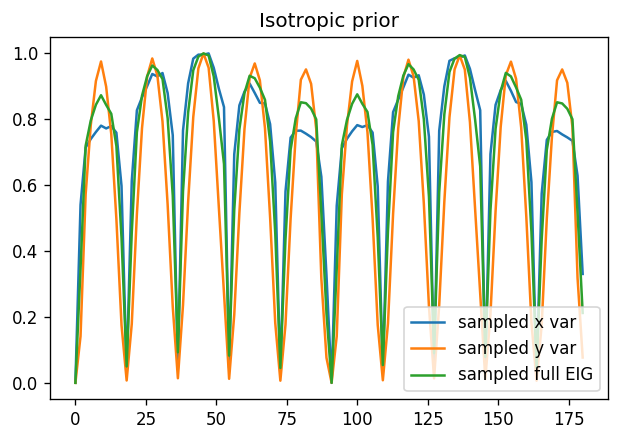

In [365]:
plt.figure(dpi=120)
# plt.plot(np.linspace(0, 180,max_angles), sampled_diag_EIG_, label='sampled diag EIG')
# plt.plot(np.linspace(0, 180,max_angles), angle_full_eig, label='full EIG')

plt.plot(np.linspace(0, 180,max_angles), (x_var_ - x_var_.min())/(x_var_.max()-x_var_.min()), label='sampled x var')
plt.plot(np.linspace(0, 180,max_angles), (y_var_ - y_var_.min())/(y_var_.max()-y_var_.min()), label='sampled y var')
plt.plot(np.linspace(0, 180,max_angles), (sampled_EIG_ - sampled_EIG_.min())/(sampled_EIG_.max()-sampled_EIG_.min()), label='sampled full EIG')
plt.title('Isotropic prior')
plt.legend()



## GP f-cov

(784, 784)


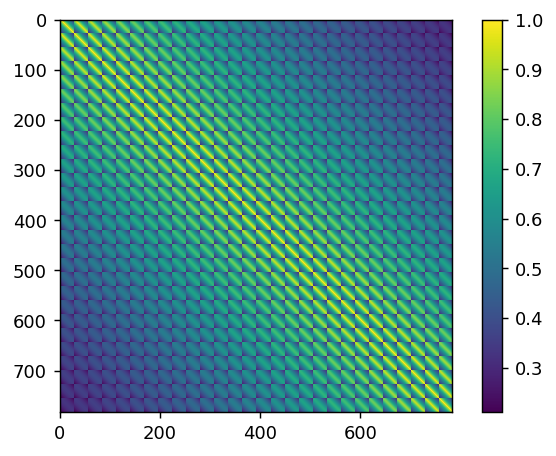

In [368]:
marg_var = 1
AR_p = 0.96
side = 28



Kff = RadialBasisFuncCov(side, marg_var, AR_p)

print(Kff.shape)
plt.figure(dpi=130)
plt.imshow(Kff)
plt.colorbar()

In [383]:
from direct_inference.utils import RadialBasisFuncCov

marg_var = 1
AR_p = 0.96
side = 28

Nsamples = 5000

Kff = RadialBasisFuncCov(side, marg_var, AR_p)

y_obs_cov = np.array(op_mat @ Kff @ op_mat.T)
y_obs_cov[np.diag_indices(y_obs_cov.shape[0])] += (noise_std ** 2)  # dy x dy
y_obs_cov_chol = jnp.linalg.cholesky(y_obs_cov)  # TODO: we can append to this with new angles and pass directly


y_non_obs_samples, f_post_samples = linear_posterior_matheron(y_obs_cov_chol=y_obs_cov_chol, f_cov=Kff, A_obs=op_mat,
                                              A_non_obs=full_op_mat, noise_std=noise_std)
y_samples_per_detector_per_angle = y_non_obs_samples.reshape(max_angles, -1, Nsamples)

# sampled_diag_EIG_GP = sampled_diag_EIG(y_samples_per_detector_per_angle, noise_std)
sampled_EIG_GP = sampled_EIG(y_samples_per_detector_per_angle, noise_std)
y_var_GP = y_var(y_samples_per_detector_per_angle, noise_std)
x_var_GP = x_var(y_samples_per_detector_per_angle, f_post_samples, full_op_tensor, noise_std)

print(y_non_obs_samples.shape)




(4100, 5000)


$y = Ax + \epsilon$


$x \~ N(0, J(y) \Sigma_{\Theta} J.T)$

$x \~ N(0, \Sigma_{ff})$

Options are 

$\Sigma_{ff} =  \lambda I$

$[\Sigma_{ff}]_{ij} = \sigma_{\theta}exp(d / l) $




$A J S (g I) ST J^T A^T + \sigma^{2} I$

(0.8, 1.01)

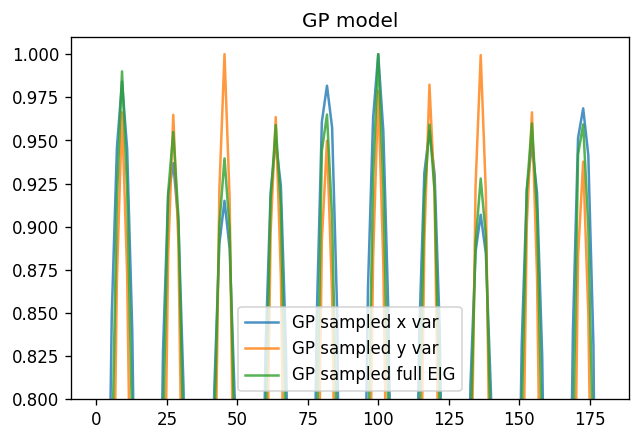

In [384]:

plt.figure(dpi=120)
# plt.plot(np.linspace(0, 180,max_angles), angle_full_eig, label='full EIG')
# plt.plot(np.linspace(0, 180,max_angles), sampled_diag_EIG_, label='sampled diag EIG')
# plt.plot(np.linspace(0, 180,max_angles), sampled_EIG_, label='sampled full EIG')
# plt.plot(np.linspace(0, 180,max_angles), sampled_diag_EIG_GP, label='sampled diag EIG GP')


# plt.plot(np.linspace(0, 180,max_angles), (x_var_ - x_var_.min())/(x_var_.max()-x_var_.min()), label='sampled x var')
# plt.plot(np.linspace(0, 180,max_angles), (y_var_ - y_var_.min())/(y_var_.max()-y_var_.min()), label='Iso sampled y var')
# plt.plot(np.linspace(0, 180,max_angles), (sampled_EIG_ - sampled_EIG_.min())/(sampled_EIG_.max()-sampled_EIG_.min()), label='sampled full EIG')

plt.plot(np.linspace(0, 180,max_angles), (x_var_GP - x_var_GP.min())/(x_var_GP.max()-x_var_GP.min()), label='GP sampled x var', alpha=0.8)
plt.plot(np.linspace(0, 180,max_angles), (y_var_GP - y_var_GP.min())/(y_var_GP.max()-y_var_GP.min()), label='GP sampled y var', alpha=0.8)
plt.plot(np.linspace(0, 180,max_angles), (sampled_EIG_GP - sampled_EIG_GP.min())/(sampled_EIG_GP.max()-sampled_EIG_GP.min()), label='GP sampled full EIG', alpha=0.8)

plt.title('GP model')
plt.legend(loc='lower center')
plt.ylim([0.8, 1.01])



In [372]:

# print(Kff.shape)
# plt.imshow(Kff)
# plt.colorbar()

# plt.figure(dpi=120)
# plt.plot(np.linspace(0, 180,max_angles), sampled_EIG_GP, label='sampled full EIG GP')
# plt.title('expected info gain')
# plt.legend()




## replicate dist mtx in pt

0.0
-0.0003361701965332031


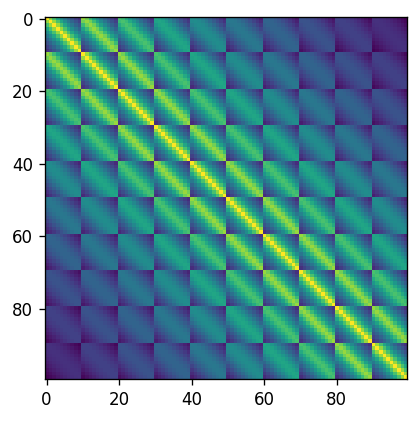

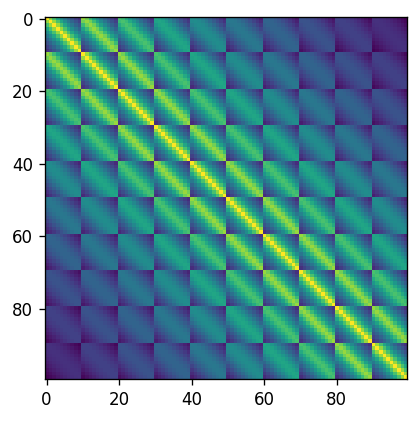

In [303]:
import torch
from direct_inference.utils import RadialBasisFuncCov, generate_dist_mtx


def generate_dist_mtx_torch(side):
    coords = np.stack([torch.repeat_interleave(torch.arange(side), side), torch.tile(torch.arange(side), (side,))], axis=1)
    coords_exp1 = coords[:,None,:]
    coords_exp0 = coords[None,:,:]
    dist_mtx = ((coords_exp1 - coords_exp0) ** 2).sum(axis=-1) ** 0.5
    return dist_mtx
      

a = generate_dist_mtx_torch(3)
b = generate_dist_mtx(3)

print((a-b).sum())



def RadialBasisFuncCov_torch(side, marg_var, log_lengthscale):
    # lengthscale = -1 / log_ar_p
    eps = 1e-5
    dist_mtx = generate_dist_mtx_torch(side)
    cov_mat = marg_var * (np.exp(- dist_mtx / torch.exp(log_lengthscale)) + eps * np.eye(side ** 2))
    return cov_mat


log_lengthscale = 2 * torch.ones(1)
side = 10
marg_var = 1.


a = RadialBasisFuncCov_torch(side, marg_var, log_lengthscale).numpy()


arp = (-1 / log_lengthscale.exp()).exp()

b = RadialBasisFuncCov(side, marg_var, float(arp))

plt.figure(dpi=120)
plt.imshow(a)
plt.figure(dpi=120)
plt.imshow(b)

print((a-b).sum())


## learning the hyperparameters with MLL

In [332]:


def linear_MLL(observation, Kyy_chol):
    half_fit = jax.scipy.linalg.cho_solve((Kyy_chol, True), observation)
#     print(half_fit.shape)
    fit_term = (half_fit * observation).sum()
    logdet_term = np.log(np.diag(Kyy_chol)).sum() * 2
    return - 0.5 * (fit_term + logdet_term)
    

    
noise_std_x = 0.00

marg_var = 1
AR_p = np.linspace(0, 0.999, 300)
MLL_list_y = []
MLL_list_x = []

for arp in AR_p:

    Kff = RadialBasisFuncCov(side, marg_var, arp)

    y_obs_cov = np.array(op_mat @ Kff @ op_mat.T)
    y_obs_cov[np.diag_indices(y_obs_cov.shape[0])] += (noise_std ** 2)  # dy x dy
    y_obs_cov_chol = jnp.linalg.cholesky(y_obs_cov)  # TODO: we can append to this with new angles and pass directly
    MLL_list_y.append(linear_MLL(observation, y_obs_cov_chol))
    
    
    Kff = Kff + np.eye(Kff.shape[0]) * (noise_std_x ** 2)  # dy x dy
    x_obs_cov_chol = jnp.linalg.cholesky(Kff)  # TODO: we can append to this with new angles and pass directly
    MLL_list_x.append(linear_MLL(image_np, x_obs_cov_chol))
    

MLL_list_y = np.stack(MLL_list_y)
MLL_list_x = np.stack(MLL_list_x)



0.932177257525
0.968929765886


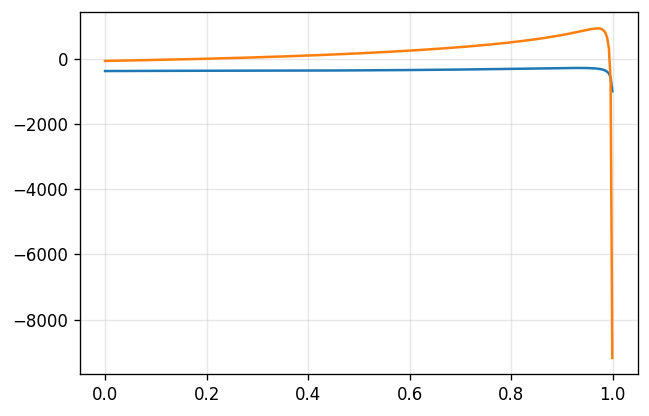

In [334]:

plt.figure(dpi=120)
plt.plot(AR_p, MLL_list_y)
plt.plot(AR_p, MLL_list_x)
plt.grid(alpha=0.3)
# plt.yscale('symlog')

# plt.xscale('log')

print(AR_p[np.argmax(MLL_list_y)])
print(AR_p[np.argmax(MLL_list_x)])
